TODO:

- break world into sectors to more quickly calculate nearby boids
- improve wall avoidance for normal trajectories
- display animation in notebook

In [811]:
import numpy as np
import random
from sklearn.preprocessing import normalize
import math
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 

%matplotlib inline

class World():
    def __init__(self, dims):
        self.dims = dims
        self.boids = np.array([])
    
    def setup(self, num_boids):
        for i in range(num_boids):
            self.add_boid()
            
    def add_boid(self):
        self.boids = np.append(self.boids, Boid(self))
        
    def run(self, steps=1):
        for i in range(steps):
            for b in self.boids:
                b.run()
        
    def render(self, frames):
        plt.style.use('dark_background')

        fig = plt.figure() 
        ax = plt.axes(xlim=(0, self.dims[0]), ylim=(0, self.dims[1])) 

        scat = ax.scatter([], [], s=5) 

        # initialization function 
        def init(): 
            # creating an empty plot/frame 
            scat.set_data([], []) 
            return scat

        # lists to store x and y axis points 
        xdata, ydata = [], [] 

        # animation function 
        def animate(i): 
            self.run(1)
            x = np.array([b.position for b in self.boids])[:,0]
            y = np.array([b.position for b in self.boids])[:,0]

            # appending new points to x, y axes points list 
            xdata.append(x) 
            ydata.append(y) 
            scat.set_offsets(np.array([b.position for b in self.boids]))
            return scat 


        # hiding the axis details 
        plt.axis('off') 

        # call the animator	 
        anim = animation.FuncAnimation(fig, animate, frames=frames, interval=20, blit=False) 

        # save the animation as mp4 video file 
        anim.save('animation.gif', writer='Pillow') 
    

class Boid(object):
    def __init__(self, world):
        self.world = world
        self.boid_num = len(self.world.boids)
        dims = self.world.dims
        x = random.randint(0, dims[0])
        y = random.randint(0, dims[1])
        self.position = np.array([x, y])
        
        direction = random.random()*2*math.pi
        initial_speed = .25
        vx = math.cos(direction)*initial_speed
        vy = math.sin(direction)*initial_speed
        self.velocity = np.array([vx, vy])
        
        self.max_speed = 2
        self.max_force = 0.05
        self.vision_angle = math.radians(270)
        self.desired_dist = random.randint(25,35)
        self.vision_dist = self.desired_dist + random.randint(75, 100)
        
        self.seen_boids = np.array([])
        self.acceleration = np.array([0, 0])
        
    def run(self):
        '''
        Find visible boids
        Separate
        Align
        Cohesion
        Avoid obstacles
        Apply Acceleration
        '''
        self.find_boids()
        
        # get forces
        sep = self.separate()
        ali = self.align()
        coh = self.cohesion()
        avo = self.avoid()
        
        sep = 2.0 * sep
        ali = 0.3 * ali
        coh = 0.5 * coh
        avo = 2.0 * avo
        #per = 0.1 * np.random.rand(2)*2 - 1
        forces = [sep, ali, coh, avo]#, per]
        #print(forces)
        self.apply_forces(forces)
        
        self.update()
    
    def update(self):
        '''

        '''
        self.velocity = self.velocity + self.acceleration
        self.velocity = self.max_speed / np.sqrt(self.velocity @ self.velocity) * self.velocity
        self.position = self.position + self.velocity
        self.position[0] = max(min(self.position[0], self.world.dims[0]), 0)
        self.position[1] = max(min(self.position[1], self.world.dims[1]), 0)
        self.acceleration = 0 * self.acceleration
    
    def apply_forces(self, forces):
        '''
        
        '''
        for f in forces:
            self.acceleration = self.acceleration + f
        
    def find_boids(self):
        '''
        This method finds boids that are within the vision distance and vision angle based on velocity direction
        '''
        # Center all positions on this boid
        dist_vecs = np.array([boid.position - self.position for boid in self.world.boids])
        # Calculate distances from this boid
        mags = np.sqrt((dist_vecs*dist_vecs).sum(axis=1))
        nearby_boids = self.world.boids[mags < self.vision_dist]
        
        
        rel_points = dist_vecs[mags < self.vision_dist]
        theta = self.vision_angle/2
        
        # Calculate roation matrices for vision sectors
        clock_rotation_matrix = np.array([[math.cos(-theta), -math.sin(-theta)],
                                        [math.sin(-theta), math.cos(-theta)]])
        counter_rotation_matrix = np.array([[math.cos(theta), -math.sin(theta)],
                                          [math.sin(theta), math.cos(theta)]])
        
        if self.vision_angle <= 180:
            sector_start = np.matmul(clock_rotation_matrix, self.velocity)
            sector_end = np.matmul(counter_rotation_matrix, self.velocity)
            visible = [not self.is_clockwise(sector_start, p) and self.is_clockwise(sector_end, p) for p in rel_points]
        else:
            sector_start = np.matmul(counter_rotation_matrix, self.velocity)
            sector_end = np.matmul(clock_rotation_matrix, self.velocity)
            visible = [not self.is_clockwise(sector_start, p) and self.is_clockwise(sector_end, p) for p in rel_points]
            visible = [not v for v in visible]
        
        self.seen_boids = nearby_boids[visible]
        
    def separate(self):
        count = 0
        steer = np.array([0, 0])
        for boid in self.seen_boids:
            diff = self.position - boid.position
            mag = np.sqrt(diff @ diff)
            if( mag > 0 and mag < self.desired_dist ):
                diff = diff / mag
                steer = steer + diff
                count += 1
        if count > 1:
            steer /= count

        steer_mag = np.sqrt(steer @ steer)
        if ( steer_mag > 0 ):
            steer = steer / steer_mag
            steer = self.max_speed * steer
            steer -= self.velocity
            steer = self.max_force / np.sqrt(steer @ steer) * steer
        return steer
    
    def align(self):
        count = len(self.seen_boids)
        steer = np.array([0, 0])
        for boid in self.seen_boids:
            steer = steer + boid.velocity
        
        if count > 1:
            steer /= count

        steer_mag = np.sqrt(steer @ steer)
        if ( steer_mag > 0 ):
            steer = steer / steer_mag
            steer = self.max_speed * steer
            steer -= self.velocity
            steer = self.max_force / np.sqrt(steer @ steer) * steer
        return steer
    
    def cohesion(self):
        count = len(self.seen_boids)
        if count==0:
            return np.array([0, 0])
        
        p = np.array([0, 0])
        for boid in self.seen_boids:
            p = p + boid.position
        p = p / count
        desired = p - self.position
        desired = desired / np.sqrt(desired @ desired) * self.max_speed
        steer = desired - self.velocity
        steer = self.max_force / np.sqrt(steer @ steer) * steer
        return steer
        
            
    
    def avoid(self):
        steer = np.array([0, 0])
        if( self.position[0] <= self.vision_dist ): # close to x0
            mag = 1 / (self.position[0] + .00001)
            steer = steer + np.array([mag, 0])
        
        if( self.position[0] >= self.world.dims[0] - self.vision_dist ): #close to max x
            mag = 1 / (self.position[0] - self.world.dims[0] + .00001)
            steer = steer + np.array([mag, 0])
            
        if( self.position[1] <= self.vision_dist ): #close to y0
            mag = 1 / (self.position[1] + .00001)
            steer = steer + np.array([0, mag])

        if( self.position[1] >= self.world.dims[1] - self.vision_dist ): #close to max y
            mag = 1 / (self.position[1] - self.world.dims[1]+ .00001)
            steer = steer + np.array([0, mag])
            
        return steer
    
    def __repr__(self):
        return f'Boid {self.boid_num} at {self.position} heading {self.velocity}'
    
    def __str__(self):
        return f'Boid {self.boid_num} at {self.position} heading {self.velocity}'
    
    def is_clockwise(self, v1, v2):
        return -v1[0]*v2[1] + v1[1]*v2[0] > 0

In [791]:
def time_test():
    world = World((500, 500))
    world.setup(100)
    world.run(100)
%timeit time_test()

3.32 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [812]:
world = World((500, 500))
world.setup(100)

MovieWriter Pillow unavailable; using Pillow instead.


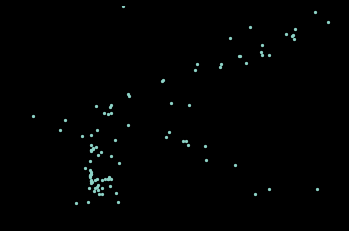

In [813]:
world.render(512)